## This notebook applies XGBoost and feature engineering methods to predict Redshift through linear regression models.

In [1]:
%load_ext autoreload
%autoreload 2
import os 
import sys
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [21]:
module_path = os.path.abspath(os.path.join('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.modeling.functions_regression import linear_regression, normal_linear_regression, evaluate, apply_scalers

In [7]:
pd.set_option("display.max_rows", 8)

In [5]:
df = pd.read_pickle("../../data/structured/df.pkl")
df

,desg,desi,desr,desz,Xaxis,desg_GP,desi_GP,desr_GP,desz_GP,wavelets,...,f14,f15,f16,f17,f18,f19,f20,type,type_bool,REDSHIFT_SPEC
ID,,,,,,,,,,,,,,,,,,,,,
SN10001,"[[0.0, 2.326, 4.792], [2.0, 4.617, 2.249], [9....","[[0.031000000002677552, 8.672, 5.439], [2.1560...","[[0.01600000000325963, 8.834, 5.339], [2.13999...","[[0.06199999999807915, 6.026, 4.693], [2.18699...","[0.0, 1.1313535353535435, 2.262707070707087, 3...","([0.0, 0.818888888888886, 1.637777777777772, 2...","([0.031000000002677552, 1.141676767679467, 2.2...","([0.01600000000325963, 1.076565656568908, 2.13...","([0.06199999999807915, 1.1927272727253795, 2.3...","[9.251771363349247, 8.972870155014132, 8.79160...",...,6.048710,-11.165995,23.954122,18.206973,6.125696,9.448978,-0.078004,II,False,0.59162
SN100023,"[[6.984000000004016, 5.679, 6.387], [7.9920000...","[[7.00800000000163, 4.698, 7.145], [8.02300000...","[[0.0, 16.04, 17.59], [6.992000000005646, 19.8...","[[4.121000000006461, 18.01, 3.601], [7.0230000...","[0.0, 1.3437474747475018, 2.6874949494950036, ...","([6.984000000004016, 8.256929292933277, 9.5298...","([7.00800000000163, 8.189737373738987, 9.37147...","([0.0, 0.8994242424242942, 1.7988484848485884,...","([4.121000000006461, 5.423121212127635, 6.7252...","[12.22728787505526, 11.357060718395505, 10.716...",...,33.710197,-11.581964,28.655932,19.743614,4.619543,37.266792,-16.596040,II,False,0.79264
SN10005,"[[10.027000000001863, 4.996, 8.081], [33.94500...","[[0.015000000006693881, 0.2977, 2.206], [18.94...","[[0.0, 1.033, 1.325], [13.015000000006694, 0.4...","[[0.03500000000349246, 1.826, 3.029], [48.875,...","[0.0, 1.0381919191919462, 2.0763838383838924, ...","([10.027000000001863, 10.782565656567513, 11.5...","([0.015000000006693881, 1.0530404040470573, 2....","([0.0, 1.0281717171717606, 2.056343434343521, ...","([0.03500000000349246, 1.0222929292964054, 2.0...","[2.000004411755352, 2.000003547336676, 2.00000...",...,-26.554909,15.768490,16.436792,17.114795,-20.292951,-24.222566,-11.295562,Ia,True,1.08327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SN99921,"[[0.0, 8.327, 4.797], [2.0, 9.834, 2.261], [9....","[[0.031000000002677552, 22.78, 5.454], [2.1560...","[[0.01600000000325963, 26.73, 5.361], [2.13999...","[[0.06199999999807915, 15.19, 4.7], [2.1869999...","[0.0, 1.2923333333333222, 2.5846666666666445, ...","([0.0, 1.1299292929293416, 2.2598585858586833,...","([0.031000000002677552, 1.3230202020228414, 2....","([0.01600000000325963, 1.3080606060638358, 2.6...","([0.06199999999807915, 1.2726666666647435, 2.4...","[14.025137598441496, 16.23859348218353, 17.966...",...,30.582545,-38.454611,33.695746,32.105615,-3.304444,32.695392,-16.237457,II,False,0.69650
SN99946,"[[11.961000000002969, 1.526, 5.683], [13.05500...","[[0.01599999999598367, 4.95, 3.147], [3.034999...","[[0.0, 0.4826, 2.129], [2.995999999999185, 0.7...","[[0.03899999999703141, 1.045, 2.483], [12.0389...","[0.0, 1.3626161616161374, 2.725232323232275, 4...","([11.961000000002969, 13.202242424245336, 14.4...","([0.01599999999598367, 1.3782121212081455, 2.7...","([0.0, 1.362181818181816, 2.724363636363632, 4...","([0.03899999999703141, 1.4012222222192594, 2.7...","[3.7693816011787566, 5.06053615747151, 6.78000...",...,95.149318,183.911735,62.540837,28.895781,-271.089743,54.766348,39.960405,Ia,True,0.40625
SN9999,"[[8.942000000002736, 3.615, 5.646], [18.930000...","[[0.0, 11.54, 6.741], [7.9650000000037835, 4.9...","[[8.95400000000518, 0.9289, 4.33], [18.9380000...","[[7.973000000005413, 3.831, 6.472], [18.954000...","[0.0, 1.383727272727287, 2.767454545454574, 4....","([8.942000000002736, 10.114111111113816, 11.28...","([0.0, 1.383727272727287, 2.767454545454574, 4...","([8.95400000000518, 10.247202020207146, 11.540...","([7.973000000005413, 9.155171717177092, 10.337...","[4.850644791493887, 5.421672218074873, 6.00573...",...,-0.255811,27.946895,12.027626,-11.213953,2.524682,-3.917774,7.161194,II,False,0.54982


### Redshift Analysis

In [8]:
df.REDSHIFT_SPEC.describe()

count    21291.000000
mean         0.669160
std          0.236500
min          0.023250
25%          0.486090
50%          0.667460
75%          0.859225
max          1.115250
Name: REDSHIFT_SPEC, dtype: float64

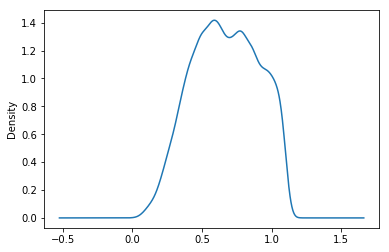

In [12]:
df.REDSHIFT_SPEC.plot.kde()

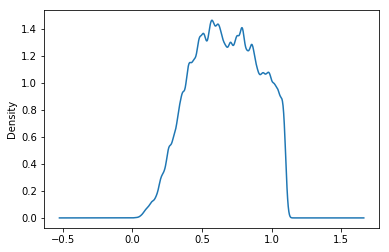

In [22]:
df.REDSHIFT_SPEC.plot.kde(bw_method=0.05)

### Evaluation Metrics Study

Using MAE, we can put a lower and upper bound on RMSE.

    [MAE] ≤ [RMSE]. The RMSE result will always be larger or equal to the MAE. If all of the errors have the same magnitude, then RMSE=MAE.
    [RMSE] ≤ [MAE * sqrt(n)], where n is the number of test samples. The difference between RMSE and MAE is greatest when all of the prediction error comes from a single test sample. The squared error then equals to [MAE^2 * n] for that single test sample and 0 for all other samples. Taking the square root, RMSE then equals to [MAE * sqrt(n)].

    Focusing on the upper bound, this means that RMSE has a tendency to be increasingly larger than MAE as the test sample size increases.

This can problematic when comparing RMSE results calculated on different sized test samples, which is frequently the case in real world modeling.
Conclusion

RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

From an interpretation standpoint, MAE is clearly the winner. RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.

On the other hand, one distinct advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in many mathematical calculations (not discussed in this article, another time…).

# ---------------------------------------------

## First analysis: Do we see such a difference if we train/test with 1100 instead of 21k ? 
### Running real case vs normal (ideal) case

In [19]:
regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
X = df.loc[:,'f1':'f20']
y = np.array(df.REDSHIFT_SPEC)
ans_real_19 = linear_regression(X, y, int(len(df)/1100), 5, regressor)
ans_real_2 = linear_regression(X, y, 2, 5, regressor)
ans_normal = normal_linear_regression(X, y, 5, regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.21604570925483899 
 Validate 2:  0.20487603052710918 
 No Validation:  0.20291589691530348

 MAE Means : 
 
 Validate 19:  0.18087175347977422 
 Validate 2:  0.17043753354020633 
 No Validation:  0.16843508925504702

 R2 Means : 
 
 Validate 19:  0.16540352410345993 
 Validate 2:  0.24947351165592976 
 No Validation:  0.26345156697804123


### Ans: Not that much

# ---------------------------------------------

## Second  analysis, Scaling values before training

#### WithMinMax MinMax and Robust Scaler

In [22]:
df_scaled, df_scaled_twice = apply_scalers(df, 20)

In [23]:
ans_real_19 = linear_regression(df_scaled_twice, y, int(len(df)/1100), 5, regressor)
ans_real_2 = linear_regression(df_scaled_twice, y, 2, 5, regressor)
ans_normal = normal_linear_regression(df_scaled_twice, y, 5, regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.2160456825558131 
 Validate 2:  0.2048761872575971 
 No Validation:  0.202915879280149

 MAE Means : 
 
 Validate 19:  0.1808717748220493 
 Validate 2:  0.17043778261986986 
 No Validation:  0.1684350493011773

 R2 Means : 
 
 Validate 19:  0.1654037289623479 
 Validate 2:  0.24947235573374837 
 No Validation:  0.2634516927381191


#### With only Robust Scaler

In [33]:
ans_real_19 = linear_regression(df_scaled, y, int(len(df)/1100), 5, regressor)
ans_real_2 = linear_regression(df_scaled, y, 2, 5, regressor)
ans_normal = normal_linear_regression(df_scaled, y, 5, regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.21604570925483899 
 Validate 2:  0.20487603052710918 
 No Validation:  0.20291589691530348

 MAE Means : 
 
 Validate 19:  0.18087175347977422 
 Validate 2:  0.17043753354020633 
 No Validation:  0.16843508925504702

 R2 Means : 
 
 Validate 19:  0.16540352410345993 
 Validate 2:  0.24947351165592976 
 No Validation:  0.26345156697804123


In [37]:
normal = 0.18087175347977422 
two_scales =  0.1808717748220493
robust_only = 0.18087175347977422 

In [39]:
normal < two_scales

True

In [44]:
normal == robust_only 

True

In [42]:
robust_only < normal

False

### Ans: Normal is already Robust scaled, 
### Scaling with MinMax get worse, but only after 10^-7. Almost nothing

# ---------------------------------------------
## Third  analysis, Comparing XGBoost with Standard linear regressions.

#### Linear Regression

In [49]:
lin_regressor = LinearRegression()
ans_real_19 = linear_regression(X, y, int(len(df)/1100), 5, lin_regressor)
ans_real_2 = linear_regression(X, y, 2, 5, lin_regressor)
ans_normal = normal_linear_regression(X, y, 5, lin_regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.457299926727576 
 Validate 2:  0.3230021618573106 
 No Validation:  0.2845866465485521

 MAE Means : 
 
 Validate 19:  0.18896920956868293 
 Validate 2:  0.18661986259906924 
 No Validation:  0.1873529358052019

 R2 Means : 
 
 Validate 19:  -2.910207502714059 
 Validate 2:  -0.8726183095960544 
 No Validation:  -0.48377809928673515


#### Ridge Regression

In [56]:
ridge_regressor = Ridge(alpha=1)
ans_real_19 = linear_regression(X, y, int(len(df)/1100), 5, ridge_regressor)
ans_real_2 = linear_regression(X, y, 2, 5, ridge_regressor)
ans_normal = normal_linear_regression(X, y, 5, ridge_regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.45729984098797266 
 Validate 2:  0.3230021550293714 
 No Validation:  0.28458664512762194

 MAE Means : 
 
 Validate 19:  0.18896920553083002 
 Validate 2:  0.18661986245955972 
 No Validation:  0.18735293577170517

 R2 Means : 
 
 Validate 19:  -2.910206048518487 
 Validate 2:  -0.8726182317165769 
 No Validation:  -0.48377808272506756


#### Ridge Normalized

In [61]:
ridge_regressor = Ridge(alpha=1, normalize = True)
ans_real_19 = linear_regression(X, y, int(len(df)/1100), 5, ridge_regressor)
ans_real_2 = linear_regression(X, y, 2, 5, ridge_regressor)
ans_normal = normal_linear_regression(X, y, 5, ridge_regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.2315236258326573 
 Validate 2:  0.22523737694724205 
 No Validation:  0.22526904971584966

 MAE Means : 
 
 Validate 19:  0.18737082452294743 
 Validate 2:  0.19023600589858533 
 No Validation:  0.1907840536721026

 R2 Means : 
 
 Validate 19:  0.03980239101575487 
 Validate 2:  0.09287946627344348 
 No Validation:  0.09231173490692579


#### Ridge with tolerance

In [58]:
ridge_regressor = Ridge(alpha=1, normalize = True, tol=0.00001)
ans_real_19 = linear_regression(X, y, int(len(df)/1100), 5, ridge_regressor)
ans_real_2 = linear_regression(X, y, 2, 5, ridge_regressor)
ans_normal = normal_linear_regression(X, y, 5, ridge_regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.2315236258326573 
 Validate 2:  0.22523737694724205 
 No Validation:  0.22526904971584966

 MAE Means : 
 
 Validate 19:  0.18737082452294743 
 Validate 2:  0.19023600589858533 
 No Validation:  0.1907840536721026

 R2 Means : 
 
 Validate 19:  0.03980239101575487 
 Validate 2:  0.09287946627344348 
 No Validation:  0.09231173490692579


### ANS: Normalize makes difference, tol do not.

#### Lasso Regrssion

In [62]:
lasso_regressor = Lasso(alpha=1, normalize = True)
ans_real_19 = linear_regression(X, y, int(len(df)/1100), 5, lasso_regressor)
ans_real_2 = linear_regression(X, y, 2, 5, lasso_regressor)
ans_normal = normal_linear_regression(X, y, 5, lasso_regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.23661582136383139 
 Validate 2:  0.23649401731007624 
 No Validation:  0.236503855192043

 MAE Means : 
 
 Validate 19:  0.1997466131584448 
 Validate 2:  0.1996708530168731 
 No Validation:  0.19968300969313874

 R2 Means : 
 
 Validate 19:  -0.0010295569096741219 
 Validate 2:  -2.7945082319891234e-05 
 No Validation:  -0.00042488071704225303


#### Elastic Search

In [63]:
elastic_regressor = ElasticNet(alpha=1, normalize = True)
ans_real_19 = linear_regression(X, y, int(len(df)/1100), 5, elastic_regressor)
ans_real_2 = linear_regression(X, y, 2, 5, elastic_regressor)
ans_normal = normal_linear_regression(X, y, 5, elastic_regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.23661582136383139 
 Validate 2:  0.23649401731007624 
 No Validation:  0.236503855192043

 MAE Means : 
 
 Validate 19:  0.1997466131584448 
 Validate 2:  0.1996708530168731 
 No Validation:  0.19968300969313874

 R2 Means : 
 
 Validate 19:  -0.0010295569096741219 
 Validate 2:  -2.7945082319891234e-05 
 No Validation:  -0.00042488071704225303


### ANS: XGBoost the best so far.
#### Scaling with MinMax get worse, but only after 10^-7. Almost nothing.


# ---------------------------------------------

## Fourth Analysis - Compare real Kde with best model predicted  Kde

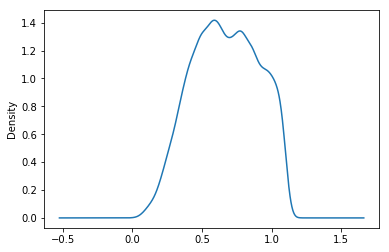

In [67]:
df.REDSHIFT_SPEC.plot.kde()

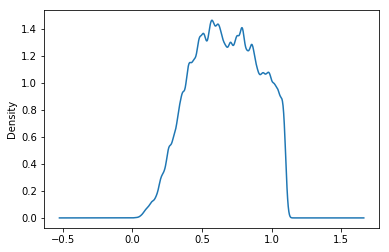

In [65]:
df.REDSHIFT_SPEC.plot.kde(bw_method=0.05)

In [82]:
df.REDSHIFT_SPEC.describe()

count    21291.000000
mean         0.669160
std          0.236500
min          0.023250
25%          0.486090
50%          0.667460
75%          0.859225
max          1.115250
Name: REDSHIFT_SPEC, dtype: float64

In [68]:
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
X = df.loc[:,'f1':'f20']
y = np.array(df.REDSHIFT_SPEC)
ans_real_19 = linear_regression(X, y, int(len(df)/1100), 5, xgb_regressor)

### Assessing if values of error from samples follow the same error

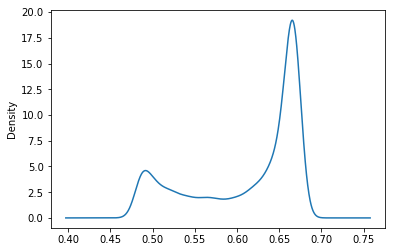

In [83]:
pd.Series(ans_real_19[0]['true_preds']).plot.kde()

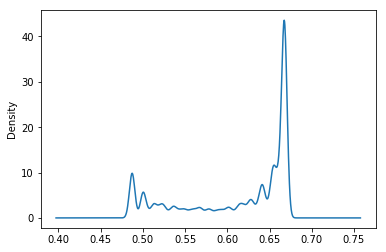

In [84]:
pd.Series(ans_real_19[0]['true_preds']).plot.kde(bw_method=0.05)

In [88]:
pd.Series(ans_real_19[0]['true_preds']).describe()

count    20170.000000
mean         0.612776
std          0.065114
min          0.487252
25%          0.558263
50%          0.647666
75%          0.667518
max          0.667518
dtype: float64

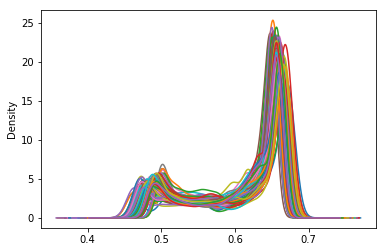

In [80]:
for i in range(95):
    pd.Series(ans_real_19[i]['true_preds']).plot.kde()
    #pd.Series(ans_real_19[i]['true_preds']).plot.kde(bw_method=0.05)

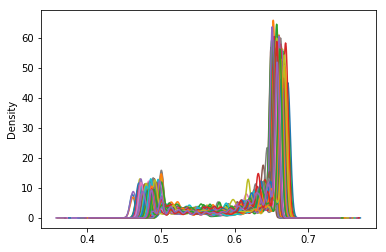

In [81]:
for i in range(95):
    pd.Series(ans_real_19[i]['true_preds']).plot.kde(bw_method=0.05)

### ANS: Models follow the same prediction pattern regardless the data used to train.